In [51]:
import numpy as np
import itertools
import h5py

In [22]:
items = []
def addGroup(name,obj):
    if isinstance(obj,h5py.Group):
        items.append(addGroup)
with h5py.File('test.h5','r') as f:
    f.visititems(func)
    
print([''.join(x.split('/')) for x in items])
#print([''.join(x.split('/')[1:])  for x in items if 'Data' not in x])

['0', '00', '01', '02', '03']


In [104]:

class Data():
    def __init__(self,data=None):
        self.copy(data)
    
    def copy(self,data):
        if data is None:
            self.data = np.zeros((4,))
        else:
            self.data = data.data.copy()
class Node():
    def __init__(self,indx,parent=None,data=None):
        self.indx = indx
        self.level = len(indx)-1
        self.global_index = (0,0,0)
        self.parent = parent
        if parent is not None:
            self.global_index = self.calc_global_index(*parent.global_index)
        self.leaf = True
        self.child = [None]*4
        
        self.data = Data(data)
    def calc_global_index(self,k,i,j):
        """
        Calculate the global index for the cell given (k,i,j).
        (k,i,j) can either be from the level above or the level below
        """
        if k==self.level:
            # Same level
            return (k,i,j)
        elif k < self.level:
            # Going from coarser level
            inew = 2*i + i//2
            jnew = 2*j + j%2
            return (k+1,inew,jnew)
        else:
            # Going from finer level
            inew = i // 2
            jnew = j // 2
            return (k-1,inew,jnew)
    def name_from_index(self,k,i,j):
        """
        Calculate the name of the cell corresponding to 
        global index (k,i,j)
        """
        name = []
        icurr = i
        jcurr = j
        for curr_level in range(k+1)[::-1]:
            name.append(str(2*(icurr%2)+jcurr%2))
            icurr = icurr // 2
            jcurr = jcurr // 2
        return ''.join(name[::-1])
    def index_from_name(self,name):
        """
        Calculate the index of the cell corresponding to 
        the given name
        """
        icurr = 0
        jcurr = 0
        for k,c in enumerate(name):
            icurr = 2*icurr + int(c)//2
            jcurr = 2*jcurr + int(c)%2
        
        return (len(name)-1,icurr,jcurr)
            
            
    def split(self):
        self.leaf = False
        for i in range(4):
            name = self.indx + str(i)
            self.child[i] = Node(name,self)
        return self.child
    def find_neighbors(self):
        """Start with neighbors on same level"""
        myindx = self.global_index
        n_name = []
        n_name_upper = []
        for i in range([-1,0,1]):
            for j in range([-1,0,1]):
                if ~((i==0)&(j==0)):
                    nindx = (myindx[0], myindx[1]+i,myindx[2]+j)
                    nindx_upper = (nindx[0]-1,nindx[1]//2,nindx[2]//2)
                    n_name.append( self.name_from_index(nindx))
                    n_name_upper.append(self.name_from_index( nindx_upper))
        return n_name, n_name_upper
    def eval_neighbors(self,neighbors,neighbors_upper,cuttof=10.):
        res = False
        for n,nu in zip(neighbors,neighbors_upper):
            node = self.find(nu)
            if node.leaf:
                res |= (node.compare(self) or node.r_flag)
            else:
                res |= (node.child[int(n[-1])].compare(self) or node.r_flag)
        return res
    def check_refinement(self,cuttoff=10.):
        neighbors, neighbors_upper = self.find_neighbors()
        self.refine = self.eval_neighbors(neighbors,neighbors_upper,cuttoff=cuttoff)
        return self.refine
    def compare(self,node,cuttoff=10.):
        return abs(self.data.data[0] - node.data.data[0]) < cuttoff 
    def find(self,name):
    """
       Find the next step towards the desired 
       node with name name.
    """ 
        len_myself = len(self.indx)
        len_name = len(name)
        if self.indx == name:
            # Found it!
            return self
        if len_myself < len_name:
            if self.indx == name[:len_myself]:
                # It's below us in the tree
                child = name[:len_myself+1][-1]
                return self.down(int(child)).find(name)
        # It's not below us, so move up
        return self.up().find(name)
        
    def up(self):
        return self.parent
    def down(self,i=0):
        return self.child[i] 
    def walk(self):
        if self.leaf:
            return self
        for c in self.child:
            return c.walk()
    def save(self,f):
        f.create_dataset('Data',data=self.data)
        if not self.leaf:
            for i,c in enumerate(self.child):
                grp = f.create_group(str(i))
                c.save(grp)
        
    def __repr__(self):
        return self.indx
    def __str__(self):
        return self.indx

In [100]:
root = [Node('0')]
root.append(root[0].split())
for i in range(7):
    root.append(list(itertools.chain.from_iterable([x.split() for x in root[-1]])))
    


In [154]:
for j in range(1,4):
    for i in range(4):
        print('{:d}: {:d} -> {:d}'.format(j,i,i^j))

1: 0 -> 1
1: 1 -> 0
1: 2 -> 3
1: 3 -> 2
2: 0 -> 2
2: 1 -> 3
2: 2 -> 0
2: 3 -> 1
3: 0 -> 3
3: 1 -> 2
3: 2 -> 1
3: 3 -> 0


In [164]:
for i in range(4):
    print('{:d} -> {:d}'.format(i,i//2))

0 -> 0
1 -> 0
2 -> 1
3 -> 1


In [170]:
for indx in [ (2**4,2**4),(2**4,2**4+1),(2**4+1,2**4),(2**4+1,2**4+1)]:
    print('({:d},{:d},{:d}) -> ({:d},{:d},{:d})'.format(4,indx[0],indx[1],3,indx[0]//2 + indx[0]%2,indx[1]//2 + indx[1]%2))

(4,16,16) -> (3,8,8)
(4,16,17) -> (3,8,9)
(4,17,16) -> (3,9,8)
(4,17,17) -> (3,9,9)


In [181]:
for indx in [ (2**4,2**4),(2**4,2**4+1),(2**4+1,2**4),(2**4+1,2**4+1)]:
    print(indx,[x%2 for x in indx],2*(indx[0]%2)+indx[1]%2)

(16, 16) [0, 0] 0
(16, 17) [0, 1] 1
(17, 16) [1, 0] 2
(17, 17) [1, 1] 3


In [186]:
k,i,j = (5,14,7)
name = []
icurr = i
jcurr = j
for curr_level in range(k+1)[::-1]:
    print((curr_level,icurr,jcurr))
    name.append(str(2*(icurr%2)+jcurr%2))
    icurr = icurr // 2
    jcurr = jcurr // 2
print(''.join(name[::-1]))

(5, 14, 7)
(4, 7, 3)
(3, 3, 1)
(2, 1, 0)
(1, 0, 0)
(0, 0, 0)
002331


In [195]:
icurr = 0
jcurr = 0
print(len('002331'))
for k,c in enumerate('002331'):
    icurr = 2*icurr + int(c)//2
    jcurr = 2*jcurr + int(c)%2
    print((k,icurr,jcurr))

6
(0, 0, 0)
(1, 0, 0)
(2, 1, 0)
(3, 3, 1)
(4, 7, 3)
(5, 14, 7)


In [40]:
list(itertools.chain.from_iterable(l2))

[000,
 001,
 002,
 003,
 010,
 011,
 012,
 013,
 020,
 021,
 022,
 023,
 030,
 031,
 032,
 033]

In [196]:
n1 = '002331'
n0 = '00201'

In [219]:
n1.split('0023')

['', '31']

In [220]:
[(n0[:i],(n0[:i] in n1)) for i in range(1,len(n0)+1)]

[('0', True), ('00', True), ('002', True), ('0020', False), ('00201', False)]

In [217]:
n0[:-1],n0[-1]

('0020', '1')

In [2]:
for c in '0023':
    print(c)

0
0
2
3


In [28]:
file = h5py.File('test.h5','r')

In [145]:
def make_node(f,level):
    if level > 10:
        f.create_dataset('Data',data=np.random.rand(4,))
        return
    if np.random.rand() < .3:
        f.create_dataset('Data',data=np.random.rand(4,))
    else:
        for i in range(4):
            grp = f.create_group(str(i))
            make_node(grp,level+1)
    return
    
with h5py.File('test5.h5','w') as f:
    root = f.create_group('0')
    level = 0
    for i in range(4):
        grp = root.create_group(str(i))
        make_node(grp,level+1)
        
       

            

In [110]:
class Tree():
    def __init__(self,fname=None):
        """
            Initialize a tree from the hdf5 file fname
        """
        try:
            self.open(fname)
            
        except OSError:
            print('File not found')
            self.file = None
    
    def build(self):
        """Build the tree from the hdf5 file"""
        name,obj =  list(self.file.items())[0]
        self.root = Node('0')
        self.root.build(obj)
            
    def open(self,fname):
        self.file = h5py.File(fname,'r')
    def close(self):
        self.file.close()
        self.file = None
    def find(self,name):
        """
            Find node starting from the root
        """
        current_node = self.root
        for c in name[1:]:
            current_node = current_node.child[int(c)]
        return current_node
#     def save(self,fname):
#         with h5py.File(fname,'w') as f:
#             grp = f.create_group('0')
#             self.root.save(grp)
class Node():
    def __init__(self,indx,file=None,parent=None,data=None):
        self.indx = indx
        self.name = '/'.join(self.indx)
        self.level = len(indx)-1
        self.global_index = (0,0,0)
        self.parent = parent
        if parent is not None:
            #self.global_index = self.calc_global_index(*parent.global_index)
            self.global_index = self.index_from_name(self.indx)
        self.leaf = False
        self.rflag = False
        self.child = [None]*4
        self.file = file
        self.datastr = None
    def build(self,f):
        """Look in the hdf5 group f for child cells"""
        for name,obj in f.items():
            if isinstance(obj,h5py.Group):
                # This is a node
                self.child[int(name)] = Node(self.indx+name,parent=self,file=obj)
                self.child[int(name)].build(obj)
            elif isinstance(obj,h5py.Dataset):
                # This is a leaf
                self.leaf = True
                self.datastr = self.name + '/' + name
            else:
                # Something went wrong, as there's nothing in this group
                print('?')
                return
        return
    def calc_global_index(self,k,i,j):
        """
        Calculate the global index for the cell given (k,i,j).
        (k,i,j) can either be from the level above or the level below
        """
        if k==self.level:
            # Same level
            return (k,i,j)
        elif k < self.level:
            # Going from coarser level
            inew = 2*i + i//2
            jnew = 2*j + j%2
            return (k+1,inew,jnew)
        else:
            # Going from finer level
            inew = i // 2
            jnew = j // 2
            return (k-1,inew,jnew)
    def name_from_index(self,k,i,j):
        """
        Calculate the name of the cell corresponding to 
        global index (k,i,j)
        """
        name = []
        icurr = i
        jcurr = j
        for curr_level in range(k+1)[::-1]:
            name.append(str(2*(icurr%2)+jcurr%2))
            icurr = icurr // 2
            jcurr = jcurr // 2
        return ''.join(name[::-1])
    def index_from_name(self,name):
        """
        Calculate the index of the cell corresponding to 
        the given name
        """
        icurr = 0
        jcurr = 0
        for k,c in enumerate(name):
            icurr = 2*icurr + int(c)//2
            jcurr = 2*jcurr + int(c)%2
        
        return (len(name)-1,icurr,jcurr)
    def get_data(self):
        return self.file['Data'][...]
    def plot(self,ax):
        if self.leaf:
            self.draw(ax)
            return
        for c in self.child:
            c.plot(ax)
    def draw(self,ax):
        cmap = matplotlib.cm.get_cmap('Spectral')
        dat = self.get_data()[0]
        k,i,j=self.global_index
        dx = 1./2**k
        x = dx *i
        y = dx*j
        rect = Rectangle((x,y),dx,dx)
        ax.add_collection(PatchCollection([rect],facecolor=cmap(dat)))
    def find(self,name):
        """
           Find the next step towards the desired 
           node with name name.
        """ 
        len_myself = len(self.indx)
        len_name = len(name)
        if self.indx == name:
            # Found it!
            return self
        if len_myself < len_name:
            if self.indx == name[:len_myself]:
                # It's below us in the tree
                child = name[:len_myself+1][-1]
                return self.down(int(child)).find(name)
        # It's not below us, so move up
        return self.up().find(name)     
    def up(self):
        return self.parent
    def down(self,i=0):
        return self.child[i] 
    def walk(self):
        if self.leaf:
            print(self.global_index)
            return self
        for c in self.child:
            c.walk()
    def __repr__(self):
        return self.indx
    def __str__(self):
        return self.indx
                

In [131]:
t = Tree(fname='test5.h5')

In [132]:
t.build()

In [119]:
t.root.walk()

(1, 0, 0)
(6, 0, 32)
(6, 0, 33)
(6, 1, 32)
(6, 1, 33)
(5, 0, 17)
(6, 2, 32)
(6, 2, 33)
(6, 3, 32)
(6, 3, 33)
(5, 1, 17)
(6, 0, 36)
(6, 0, 37)
(6, 1, 36)
(6, 1, 37)
(6, 0, 38)
(6, 0, 39)
(6, 1, 38)
(6, 1, 39)
(5, 1, 18)
(6, 2, 38)
(6, 2, 39)
(6, 3, 38)
(6, 3, 39)
(6, 4, 32)
(6, 4, 33)
(6, 5, 32)
(6, 5, 33)
(5, 2, 17)
(6, 6, 32)
(6, 6, 33)
(6, 7, 32)
(6, 7, 33)
(6, 6, 34)
(6, 6, 35)
(6, 7, 34)
(6, 7, 35)
(5, 2, 18)
(6, 4, 38)
(6, 4, 39)
(6, 5, 38)
(6, 5, 39)
(6, 6, 36)
(6, 6, 37)
(6, 7, 36)
(6, 7, 37)
(5, 3, 19)
(4, 0, 10)
(4, 0, 11)
(6, 4, 40)
(6, 4, 41)
(6, 5, 40)
(6, 5, 41)
(6, 4, 42)
(6, 4, 43)
(6, 5, 42)
(6, 5, 43)
(6, 6, 40)
(6, 6, 41)
(6, 7, 40)
(6, 7, 41)
(5, 3, 21)
(4, 1, 11)
(4, 2, 8)
(6, 8, 36)
(6, 8, 37)
(6, 9, 36)
(6, 9, 37)
(5, 4, 19)
(6, 10, 36)
(6, 10, 37)
(6, 11, 36)
(6, 11, 37)
(5, 5, 19)
(5, 6, 16)
(5, 6, 17)
(5, 7, 16)
(5, 7, 17)
(4, 3, 9)
(5, 4, 20)
(6, 8, 42)
(6, 8, 43)
(6, 9, 42)
(6, 9, 43)
(6, 10, 40)
(6, 10, 41)
(6, 11, 40)
(6, 11, 41)
(6, 10, 42)
(6, 10, 43)
(6,

In [128]:
t.close()

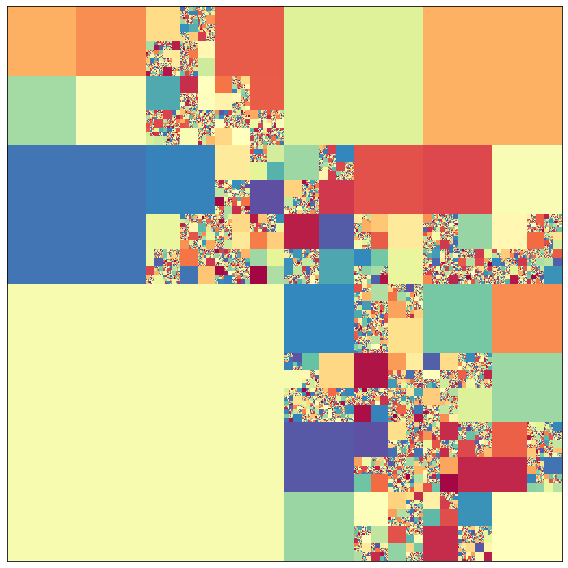

In [147]:
t = Tree(fname='test5.h5')
t.build()
fig,ax=plt.subplots(figsize=(8,8))
t.root.plot(ax)
ax.tick_params(axis='both',which='both',top='off',right='off',left='off',bottom='off',labelbottom='off',labelleft='off')
ax.set_aspect('equal')
fig.tight_layout()
fig.savefig('ex5.png',bbox_inches='tight')